# Описание датасета
С 2008 года пользователи Airbnb могут находить уникальные и персонализированные варианты проживания для путешествий по всему миру. Этот набор данных содержит информацию о листингах и их активности в Нью-Йорке в 2019 году. В нем представлены данные о хостах, географическом расположении объектов и ключевых показателях, которые могут быть использованы для анализа и прогнозирования. В данном проекте будет выполнена задача прогнозирования цены.


# Описание признаков
id — уникальный идентификатор объявления.

name — название объявления.

host_id — идентификатор владельца жилья.

neighbourhood_group — район города (например, Манхэттен, Бруклин).

neighbourhood — подрайон (конкретное местоположение внутри района).

latitude, longitude — географические координаты объекта(longitude -долгота, latitude - широта).

room_type — тип жилья (например, "Весь дом/квартира", "Частная комната" и т.д.).

price — стоимость ночи проживания (целевая переменная).

minimum_nights — минимальное количество ночей для бронирования.

number_of_reviews — общее количество отзывов.

last_review — дата последнего отзыва.

reviews_per_month — среднее количество отзывов в месяц.

calculated_host_listings_count — количество всех объявлений от одного хозяина.

availability_365 — количество дней, когда объект доступен для бронирования в течение года.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

##1. Загрузка датасета

In [2]:
!gdown --id 1jguoHyAi6QXgDlTIkIpYXZGy6vBsIckv
import pandas as pd
df = pd.read_csv('AirBnb.csv')
df.head()

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jguoHyAi6QXgDlTIkIpYXZGy6vBsIckv
To: /content/AirBnb.csv
100% 7.08M/7.08M [00:00<00:00, 32.3MB/s]


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


##2.Просмотр и предобработка данных##

Необходимо посмотреть на размер датафрейма, оценить количество пропусков и типы данных для признаков.

In [3]:
df.shape

(48895, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
df.isna().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


Посмотрим на типы данных в колонках с пропусками, чтобы правильно понимать, как их следует заполнять.


In [6]:
df[['name', 'last_review', 'reviews_per_month', "host_name"]].dtypes


,0
name,object
last_review,object
reviews_per_month,float64
host_name,object


1) name и host_name - не будем заполнять, эти признаки стоит удалить, они не несут полезной информации для анализа зависимостей и будут только мешать в построении модели.

2) Пропуски в last_review заполним NaT, посколько их довольно большое количество, помимо этого необходмо конвертировать тип данных, поскольку в дейстивительности это информация о последней дате просмотра объявления. Также создадим новый признак - есть ли дата.

3) reviews_per_month заполним медианой, поскольку это числовой столбец и медиана устойчива к выбросам.

Кроме этого, удалим колонки host_name и id, поскольку они также неинформативны и могут мешать модели.

In [7]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['last_review'] = df['last_review'].fillna(pd.NaT)


In [8]:
df['reviews_per_month']=df['reviews_per_month'].fillna(df['reviews_per_month'].median())


In [9]:
df.drop(columns=['id', 'name', "host_name", 'host_id'], inplace=True)

In [10]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,2018-10-04 01:47:23.910099456,1.238930,7.143982,112.781327
min,40.499790,-74.244420,0.000000,1.000000,0.000000,2011-03-28 00:00:00,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,2018-07-08 00:00:00,0.280000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,2019-05-19 00:00:00,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2019-06-23 00:00:00,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000
std,0.054530,0.046157,240.154170,20.510550,44.550582,NaN,1.520861,32.952519,131.622289


Как можно видеть из описания датасета, вероятно ряд колонок содержит выбросы, это можно заметить по тому, как сильно отличаются 75% квартиль и максимум. Также мы можем оценить диапазон значений, например, для целевой пременной - цена, он составляет от 0 до 10000.

Теперь посмотрим на наличие дубликатов в данных.

In [11]:
df.duplicated().sum()

np.int64(0)

## 3. Создание новых признаков

Создадим новый признаки, во-первых, цену за ночь, это позволит лучше понимать цену хоста. Во-вторых, используем наши данные о широте и долготе для расчеты актуального расстояния до центра Нью-Йорка, сами по себе эти признаки не очень информативны, а в таком виде они становятся очень полезными. Поэтому после создания нового признака, широту и долготу следует удалить.

In [12]:
df['price_per_night'] = df['price'] / df['minimum_nights']


In [13]:
from geopy.distance import geodesic

centr = (40.7128, -74.0060)
def dist(row):
    n = (row['latitude'], row['longitude'])
    return geodesic(n, centr).kilometers

df['center_distance'] = df.apply(dist, axis=1)



In [14]:
df.drop(columns=['latitude', 'longitude'], inplace=True)

In [15]:
df.head(10)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_per_night,center_distance
0,Brooklyn,Kensington,Private room,149,1,9,2018-10-19,0.21,6,365,149.000000,7.789889
1,Manhattan,Midtown,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,225.000000,4.906576
2,Manhattan,Harlem,Private room,150,3,0,NaT,0.72,1,365,50.000000,11.977809
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,89.000000,4.970672
4,Manhattan,East Harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,8.000000,10.863385
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,66.666667,4.674671
6,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,2017-10-05,0.40,1,0,1.333333,5.115744
7,Manhattan,Hell's Kitchen,Private room,79,2,430,2019-06-24,3.47,1,220,39.500000,6.052124
8,Manhattan,Upper West Side,Private room,79,2,118,2017-07-21,0.99,1,0,39.500000,10.409392
9,Manhattan,Chinatown,Entire home/apt,150,1,160,2019-06-09,1.33,4,188,150.000000,1.322629


Оценим количество уникальных значений в колонках и затем посмотрим на уникальные значения в колонках, где их меньше 10.

In [16]:
df.nunique()

,0
neighbourhood_group,5
neighbourhood,221
room_type,3
price,674
minimum_nights,109
number_of_reviews,394
last_review,1764
reviews_per_month,937
calculated_host_listings_count,47
availability_365,366


In [17]:
df['room_type'].value_counts()

,count
room_type,
Entire home/apt,25409
Private room,22326
Shared room,1160


In [18]:
df['neighbourhood_group'].value_counts()

,count
neighbourhood_group,
Manhattan,21661
Brooklyn,20104
Queens,5666
Bronx,1091
Staten Island,373


Теперь у нас есть представление о структуре данных, о том как работать с каждым из признаков.

## 4. Разведывательный анализ данных и визуализация

##4.1. Распредление категориальных данных

In [19]:
import math
df_cat =  df.select_dtypes(include=['object', 'category']).columns
df_cat = df_cat[df_cat != 'neighbourhood']
num_col = len(df_cat)
num_rows = math.ceil(num_col / 3)
num_cols = min(3, num_col)

Находим все категориальные столбцы из датасета, выбрав столбцы с типами данных object или category. Затем из полученного списка удаляем столбец neighbourhood, так как он содержит слишком много уникальных значений, что делает его нецелесообразным для дальнейшего анализа в графическом виде. После этого вычисляется количество строк и столбцов для размещения подграфиков, с учётом того, что в каждом ряду будет не более трех графиков. Таким образом, мы динамически адаптируем количество подграфиков, чтобы все они помещались в удобном формате.

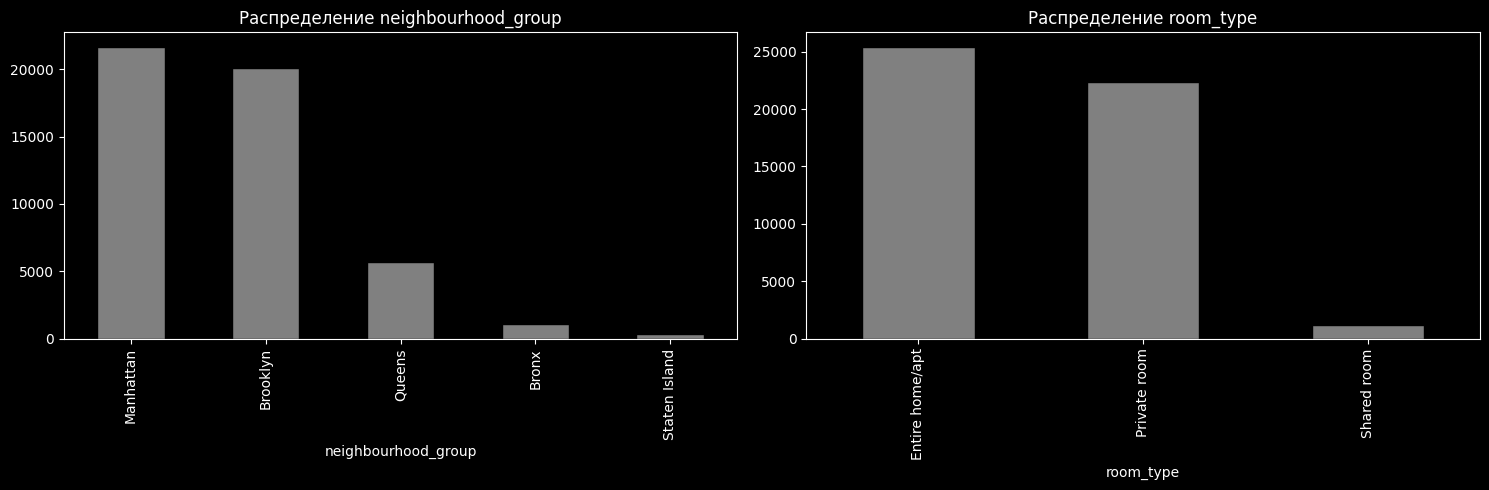

In [20]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i, col in enumerate(df_cat):
    df[col].value_counts().plot.bar(ax=axes[i], color='grey', edgecolor='black')
    axes[i].set_title(f'Распределение {col}')

plt.tight_layout()



Из результатов можно увидеть, что основной рынок аренды сосредоточен в Манхэттене и Бруклине, а большая часть предложений – это либо отдельные квартиры, либо частные комнаты. Bronx и Staten Island почти не представлены, а совместное проживание (shared room) крайне непопулярно.

Посмотрим на группы разных комнат и районов по средней цене.

In [21]:
 df.groupby('room_type')['price'].mean().reset_index()

,room_type,price
0,Entire home/apt,211.794246
1,Private room,89.780973
2,Shared room,70.127586


Как видно, одна из групп, а именно целый дом и квартира,сильно выделяется высокой ценой. Это в свою очередь объясняется тем, что такие варианты предоставляют полный доступ к жилью, что является более привлекательным для гостей, которые ищут приватность и удобство, что создает высокий спрос.

In [22]:
 df.groupby('neighbourhood_group')['price'].mean().reset_index()

,neighbourhood_group,price
0,Bronx,87.496792
1,Brooklyn,124.383207
2,Manhattan,196.875814
3,Queens,99.517649
4,Staten Island,114.812332


В данном случае, можно увидеть, что в Манхеттене средняя цена намного превосходит средние цены других районов, самый дешевый Бронкс - но он не сильно отвличется от остальной массы. В целом, цены Манхеттена объяснимы, ведь он является сердцем города Нью-Йорк, где сосредоточены финансовые, культурные и деловые центры.

##4.2 Распределение числовых данных

In [23]:
df_num = df.select_dtypes(include=['number']).columns
num_col = len(df_num)
num_rows = math.ceil(num_col / 3)
num_cols = min(3, num_col)

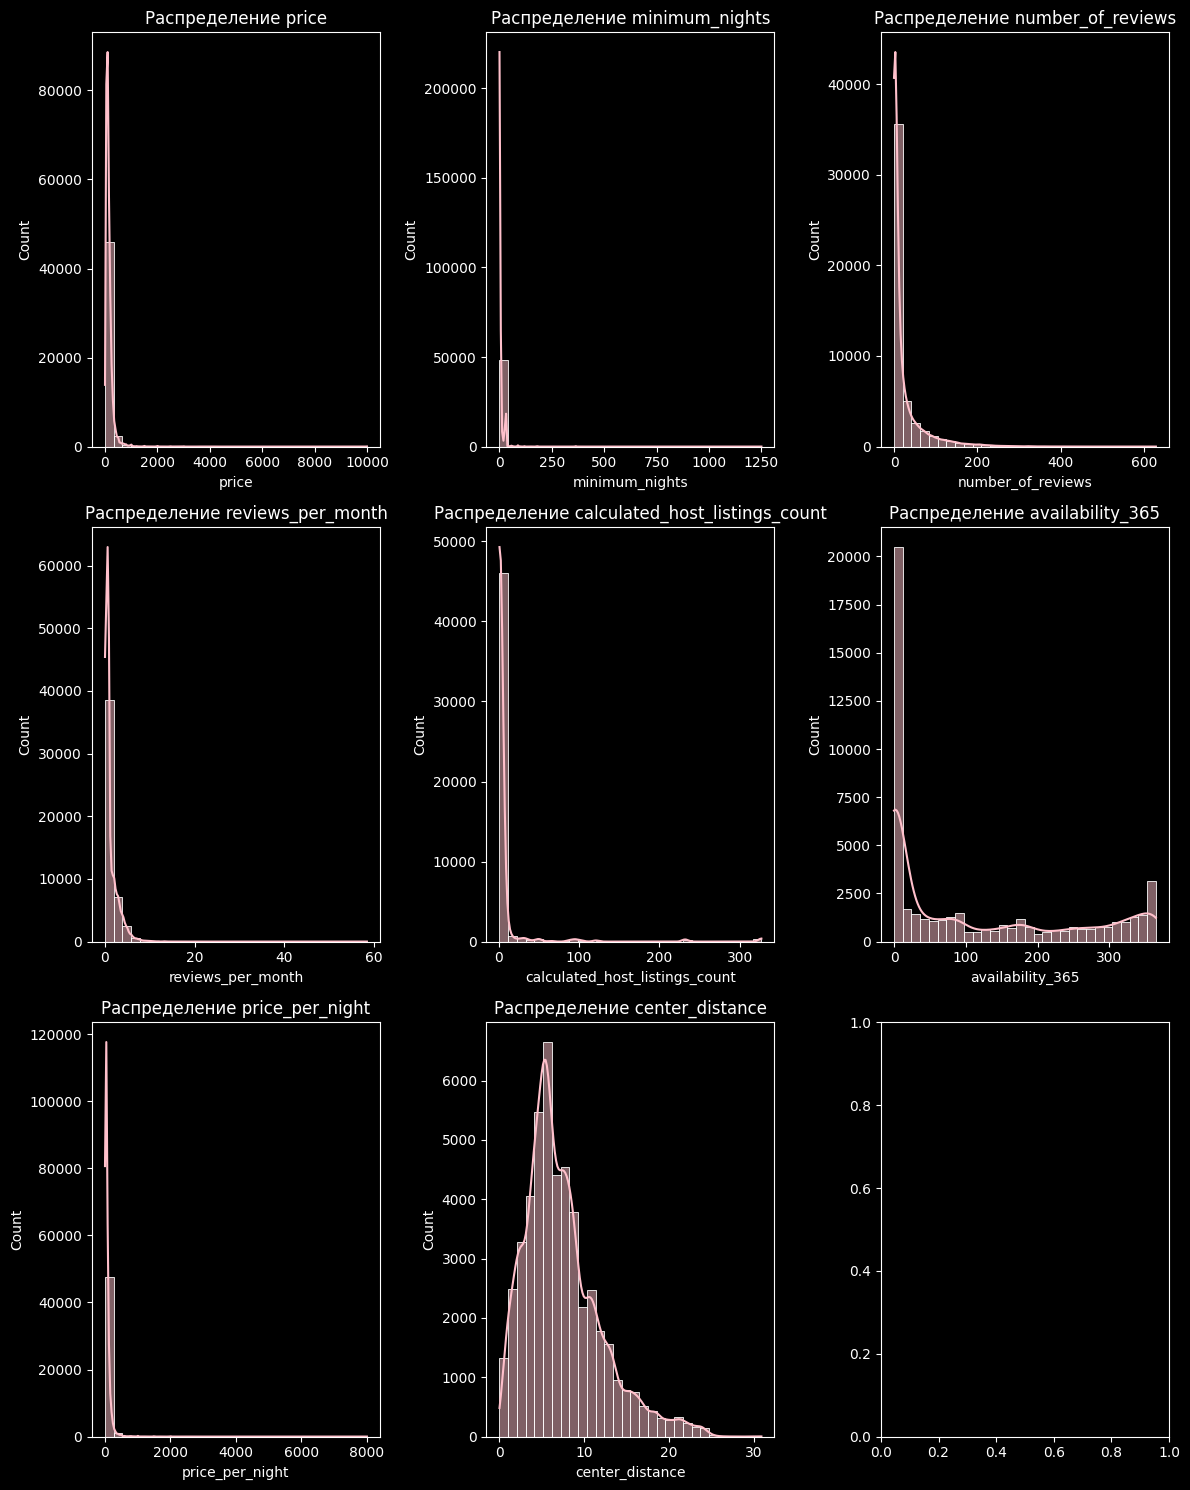

In [24]:
import seaborn as sns
fig, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows * 5))

for i, col in enumerate(df_num, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(df[col], kde=True, color='pink', bins=30)
    plt.title(f'Распределение {col}')

plt.tight_layout()


## 4.3. Анализ выбросов.

In [25]:
df_num = df.select_dtypes(include=['number']).columns
for col in df_num:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    print(f"{col}: количество выбросов = {outliers_count}")

    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


price: количество выбросов = 2972
minimum_nights: количество выбросов = 6607
number_of_reviews: количество выбросов = 6021
reviews_per_month: количество выбросов = 4103
calculated_host_listings_count: количество выбросов = 7081
availability_365: количество выбросов = 0
price_per_night: количество выбросов = 3333
center_distance: количество выбросов = 1932


In [26]:
num_cols = len(df_num)
num_rows = (num_cols + 2) // 3

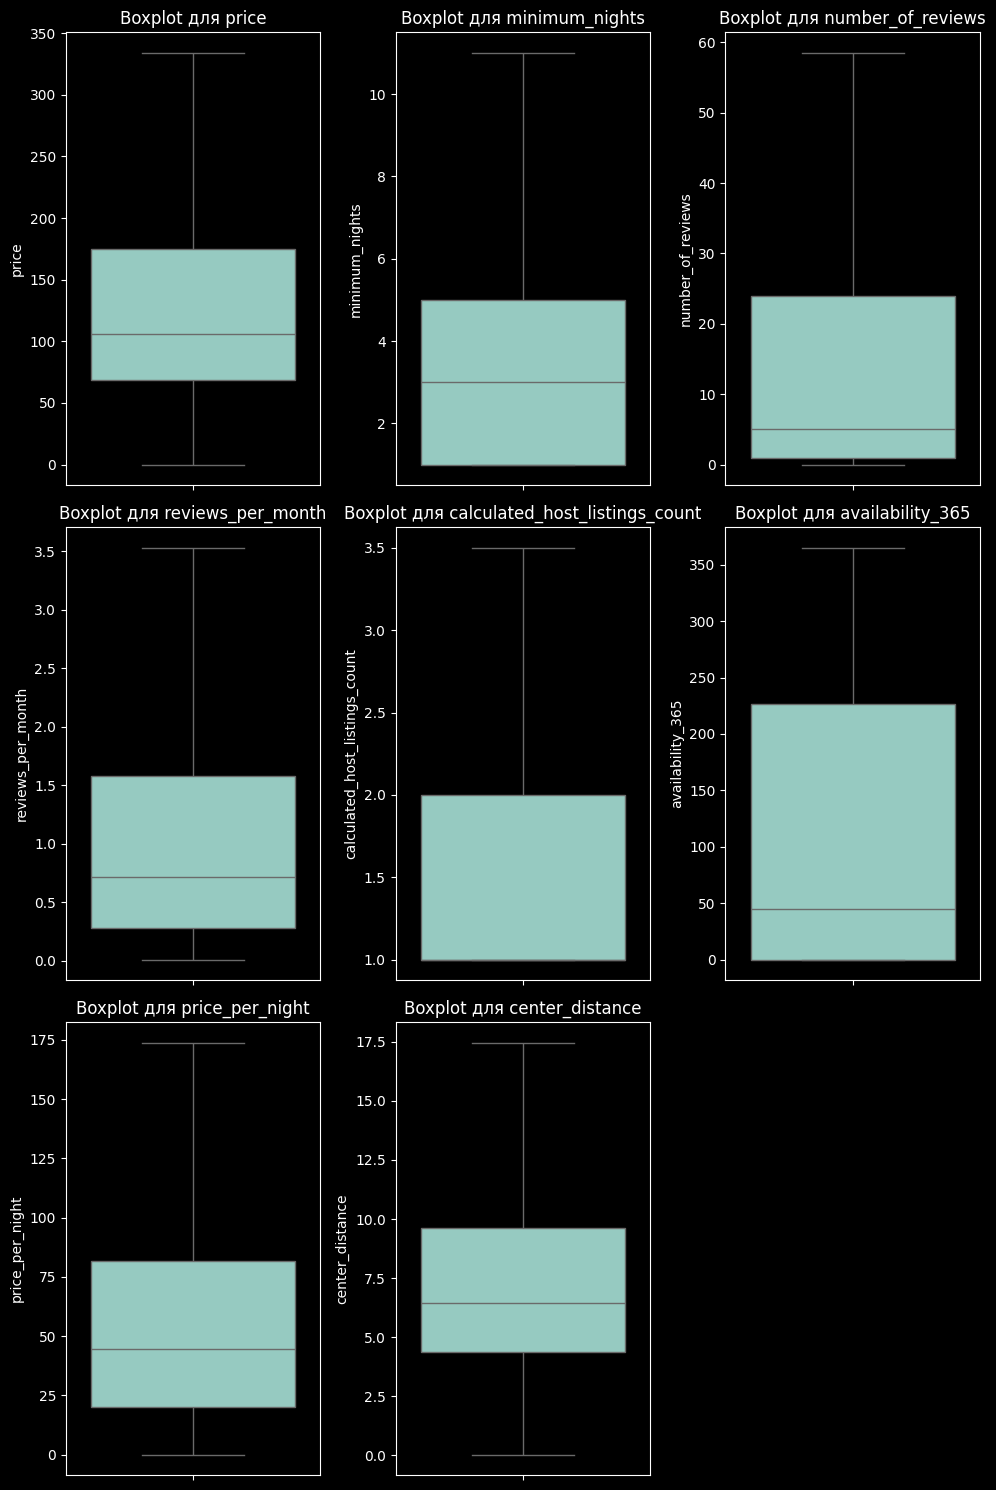

In [27]:
plt.figure(figsize=(10, num_rows * 5))
for i, col in enumerate(df_num):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot для {col}')
    plt.ylabel(col)

plt.tight_layout()

## 4.4 Корреляция между целевой переменной и числовыми признаками, визуализация.

/tmp/ipython-input-4098303256.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corr.index, x=corr, palette='hls')


Text(0, 0.5, 'Признак')

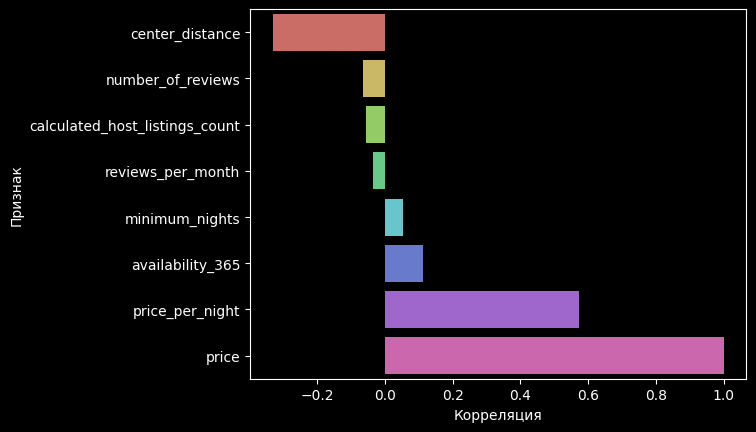

In [28]:
df_nums = df.select_dtypes(include=['number'])
corr = df_nums.corrwith(df['price']).sort_values()

sns.barplot(y=corr.index, x=corr, palette='hls')
plt.xlabel('Корреляция')
plt.ylabel('Признак')


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   neighbourhood_group             48895 non-null  object        
 1   neighbourhood                   48895 non-null  object        
 2   room_type                       48895 non-null  object        
 3   price                           48895 non-null  int64         
 4   minimum_nights                  48895 non-null  int64         
 5   number_of_reviews               48895 non-null  float64       
 6   last_review                     38843 non-null  datetime64[ns]
 7   reviews_per_month               48895 non-null  float64       
 8   calculated_host_listings_count  48895 non-null  float64       
 9   availability_365                48895 non-null  int64         
 10  price_per_night                 48895 non-null  float64       
 11  ce

Text(0, 0.5, 'Цена')

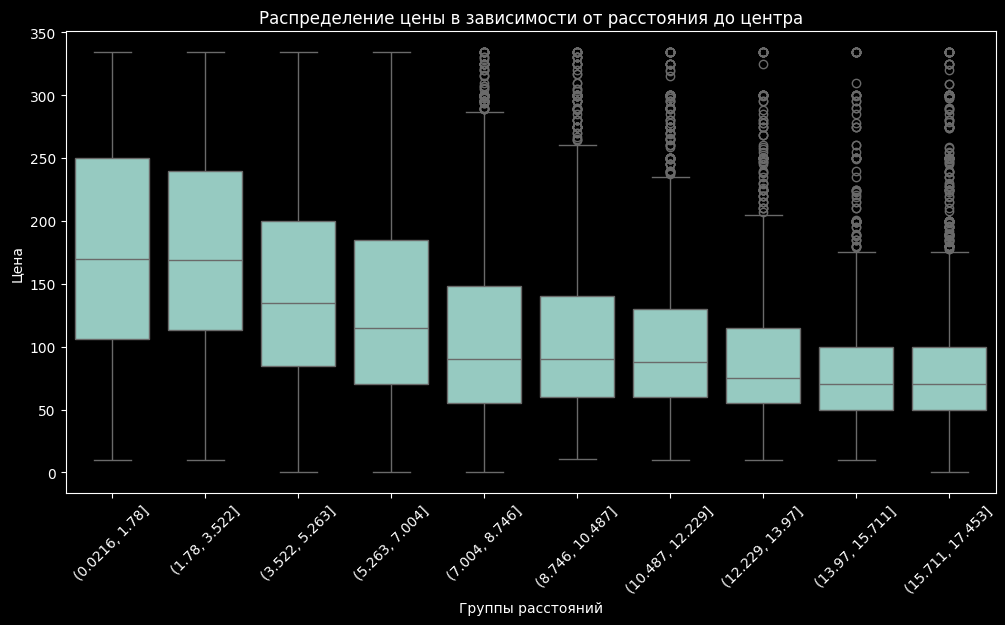

In [30]:
df['distance_group'] = pd.cut(df['center_distance'], bins=10)
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['distance_group'], y=df['price'])
plt.xticks(rotation=45)
plt.title('Распределение цены в зависимости от расстояния до центра')
plt.xlabel('Группы расстояний')
plt.ylabel('Цена')

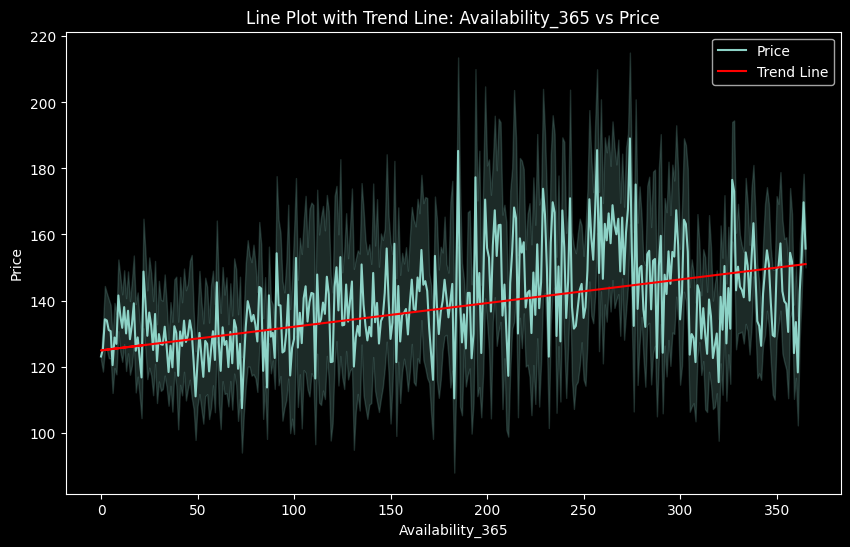

In [31]:
import numpy as np
plt.figure(figsize=(10, 6))
sns.lineplot(x='availability_365', y='price', data=df, label='Price')

z = np.polyfit(df['availability_365'], df['price'], 1)
p = np.poly1d(z)

plt.plot(df['availability_365'], p(df['availability_365']), color='red', label='Trend Line')

plt.title('Line Plot with Trend Line: Availability_365 vs Price')
plt.xlabel('Availability_365')
plt.ylabel('Price')
plt.legend()

Из графика можно увидеть незначительную связь количеством доступных дней в году и ценой, в целом с доступностью цена в среднем растет.

Text(0, 0.5, 'Frequency')

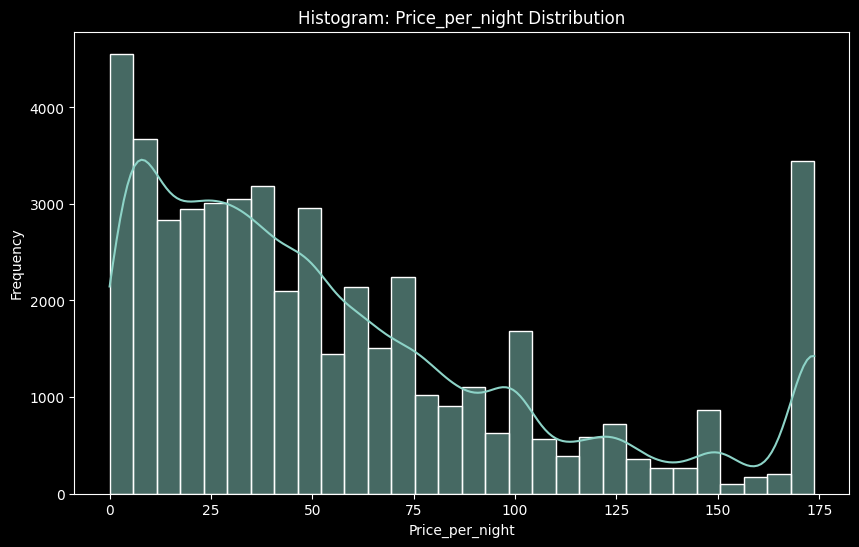

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price_per_night'], kde=True, bins=30)
plt.title('Histogram: Price_per_night Distribution')
plt.xlabel('Price_per_night')
plt.ylabel('Frequency')



Это гистограмма распределению цены за ночь, в целом, ц графика нисходящий тренд - с ростом цены частота снижается, отднако при значении 175 заметен скачок.

# 4.5 Корреляционная матрица для числовых признаков и визуализация##

Кроме оценки связи признаков с целевой пременной, интересно посмотреть на некоторые зависимости признаков между собой.

Text(0.5, 1.0, 'Корреляционная матрица')

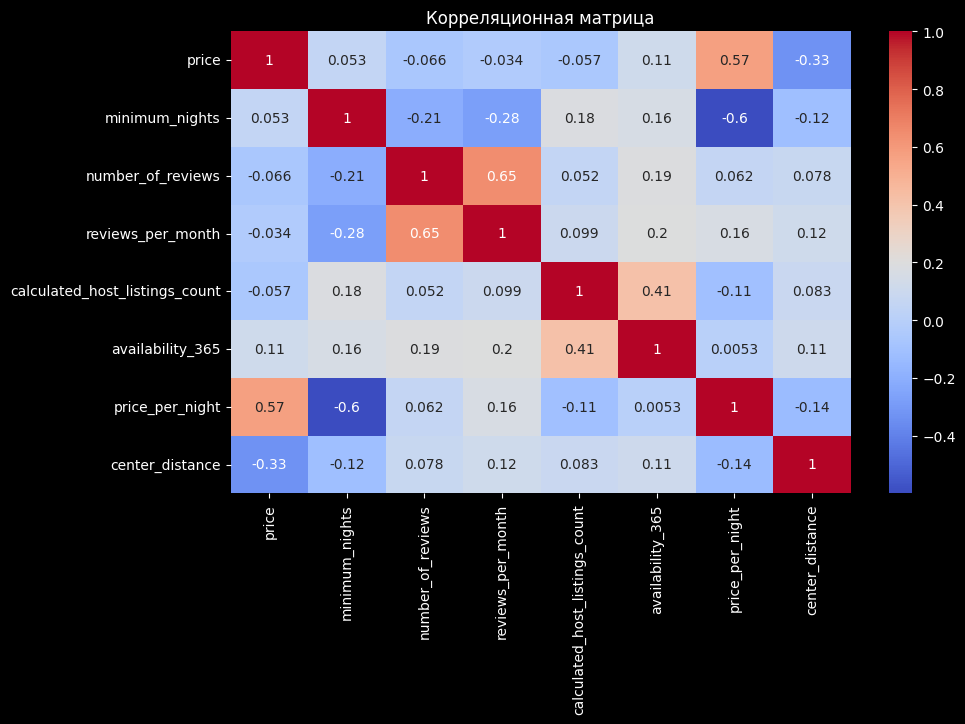

In [33]:
plt.figure(figsize=(10, 6))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')

Можно увидеть из тепловой карты корреляции какие признаки между собой сильнее всего коррелируют. Но в целом сильной корреляции не наблюдается, что в целом может быть хорошо в контексте применения линейной модели, так как это убирает риск линейной зависимости между признаками.

Text(0.5, 1.0, 'Корреляционная матрица (Метод Спирмена)')

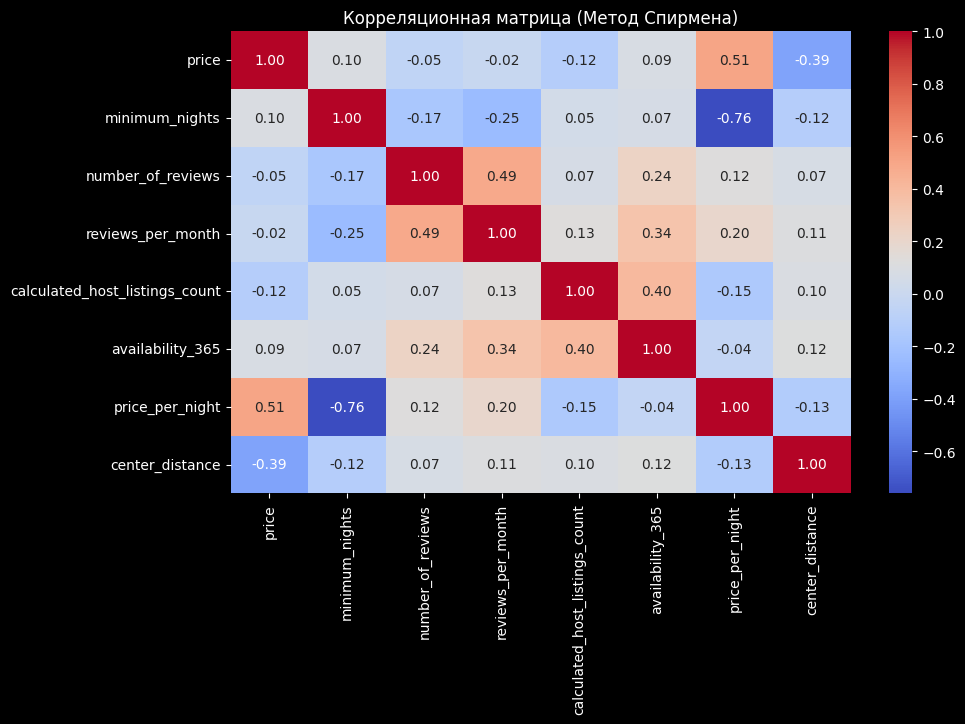

In [34]:
plt.figure(figsize=(10, 6))
corr_spearman = df.select_dtypes(include=np.number).corr(method='spearman')
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица (Метод Спирмена)')


Однако мы использовали метод Пирсона и могли упустить ряд связей из-за его ограниченности, полноценно посмотреть на связи можно используя также матод Спирмена. Можно заметить, что в такой корелляцоинной матрице, например, прослеживается более сильная корреляция между количество просмотров объявления за месяц и его доступностью в году. Хотя часть корреляций усилилась, некоторые напротив, стали слабее.

Text(0, 0.5, 'Цена за ночь')

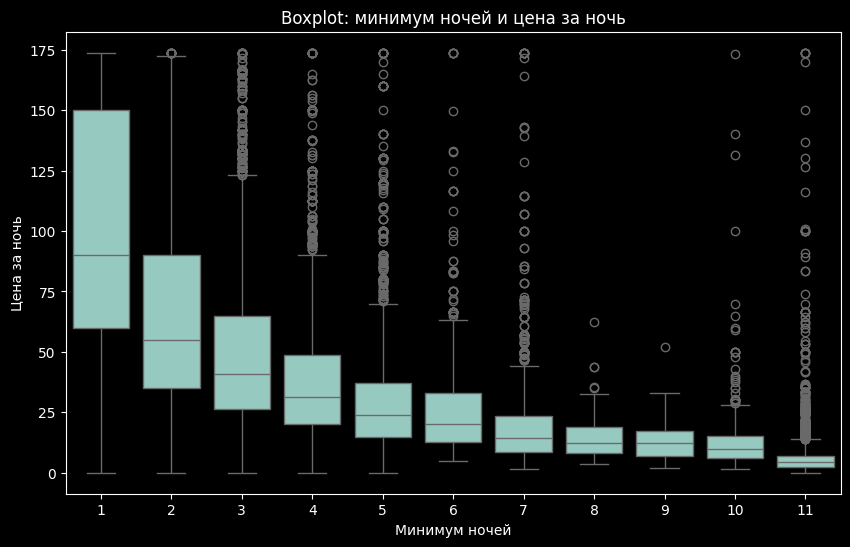

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='minimum_nights', y='price_per_night', data=df)
plt.title('Boxplot: минимум ночей и цена за ночь')
plt.xlabel('Минимум ночей')
plt.ylabel('Цена за ночь')

Как видно из гарфика, цена за ночь в среднем падает с ростом количества минимальных ночей, это говорит о том, что хозяева жилья часто предлагают скидки для гостей, которые бронируют проживание на более длительный срок. Это стимулирует гостей выбирать более долгие периоды проживания, что может снизить среднюю цену за ночь. Это похоже на оптовую продажу, где низкая цена компенсируется большим количеством.

Text(0, 0.5, 'Средняя доступность (дней в году)')

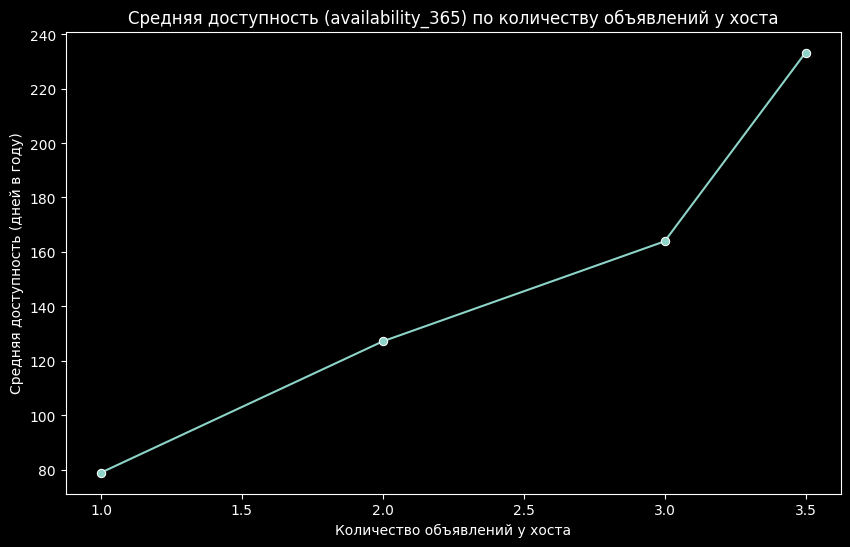

In [36]:
grouped = df.groupby("calculated_host_listings_count")["availability_365"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x="calculated_host_listings_count", y="availability_365", marker="o")
plt.title("Средняя доступность (availability_365) по количеству объявлений у хоста")
plt.xlabel("Количество объявлений у хоста")
plt.ylabel("Средняя доступность (дней в году)")

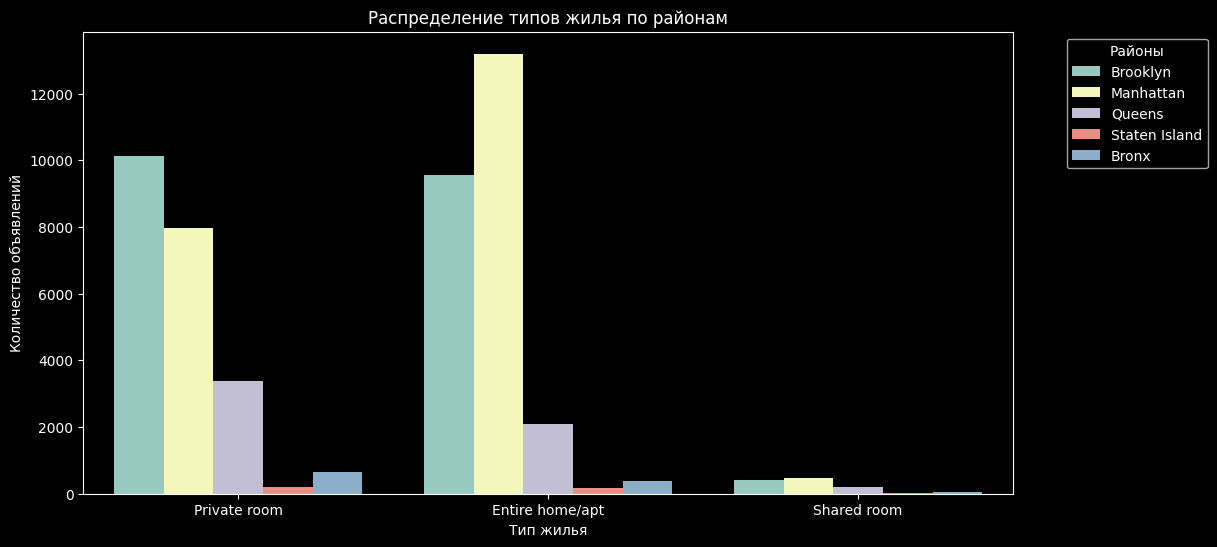

In [37]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='room_type', hue='neighbourhood_group', data=df)

plt.title('Распределение типов жилья по районам')
plt.xlabel('Тип жилья')
plt.ylabel('Количество объявлений')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, title='Районы', bbox_to_anchor=(1.05, 1), loc='upper left')


Из данного графика можно увидеть, как распрелено количество объявлений по типам жилья в разных районах. В целом распредление везде похожее, а вот количество объявлений в Манхетене самое большое, хотя Бруклин не сильно отстает. В Манхетене в основном размещены объявления для отедльного дома и квартиры, а в бруклине для отдельной комнаты.

/tmp/ipython-input-4022498916.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = df.groupby(['distance_range', 'neighbourhood_group'])['price'].mean().unstack()


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Bronx'),
  Text(1.5, 0, 'Brooklyn'),
  Text(2.5, 0, 'Manhattan'),
  Text(3.5, 0, 'Queens'),
  Text(4.5, 0, 'Staten Island')])

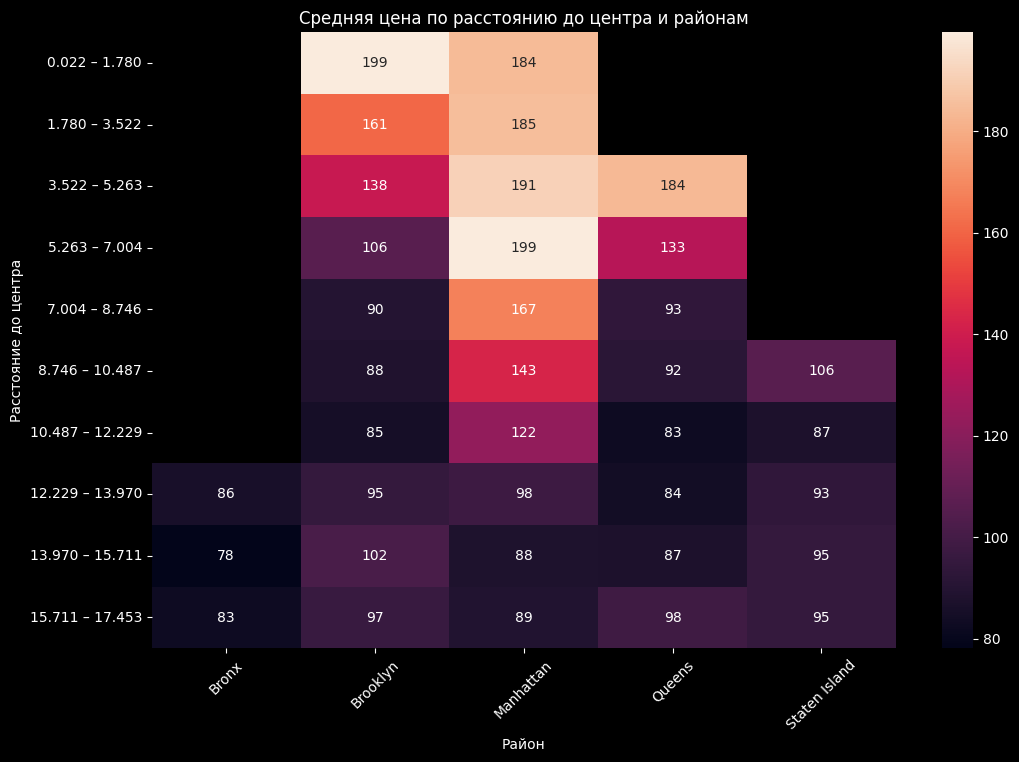

In [38]:
def format_range(x):
    return f"{x.left:.3f} – {x.right:.3f}"

dbins = pd.cut(df['center_distance'], bins=10)
df['distance_range'] = dbins.map(format_range)

pivot_table = df.groupby(['distance_range', 'neighbourhood_group'])['price'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f")
plt.title('Средняя цена по расстоянию до центра и районам')
plt.xlabel('Район')
plt.ylabel('Расстояние до центра')
plt.xticks(rotation=45)

Видна разница в районнах по ценам, Манхэттенне средние цены выше, как уже выяснилось до этого, но самая высокая цена на удивление не находится в области ближашей к центру, она располагается в 5-7 км. от центра и составляет 199 долларов. Хотя примечательно, что в Бруклине в ближайшему к центру области средняя цена превосходит  соответствующую у Манхеттена. В Квинс средняя цена тоже относительно высокая ( 184 долларов для ближайшей к центру области)


# 5. Машинное обучение.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [40]:
df["year"] = df["last_review"].dt.year
df["month"] = df["last_review"].dt.month

df["year"] = df["year"].fillna(-1)
df["month"] = df["month"].fillna(-1)

df.drop(columns=["last_review"], inplace=True)

y = df["price"]
X = df.drop(columns=["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=161)

Используем one-hot-encoding, встроенный в pandas(его использование проще, чем из sklearn), а также делим наши данные на тестовые и тренировочные. В качестве модели берем Ridge, в ней есть встроенная регуляризация, которая помогает бороться с переобучением.

In [41]:
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100],
    'ridge__solver': ['auto', 'lsqr', 'sparse_cg', 'sag'],
    'ridge__max_iter': [1000, 5000]

}
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Best parameters: {'ridge__alpha': 10, 'ridge__max_iter': 1000, 'ridge__solver': 'auto'}
Mean Squared Error: 2013.90
R-squared: 0.71


Находим лучшие гиперпараметры для нашей модели используя GridSearchCV, для этого нужно предварительно отмасшатбировали данные, поскольку для линейных моделей это критично, хорошим выбором будет StandardScaler, поскольку он относительно устойчив к выбросам. Сделали словарь параметров и их значений и передали его в GridSearchCV с 5-ти разовой кросс-валидацией и отрицательной средне-квадратичной функцией потерь(поскольку GridSearchCV по умолчанию находит гиперпараметры для максимизации функции).

Модель имеет относительно хорошее качество (r2 около 0.7 - для линейной модели довольно неплохое описание дисперсии) и не переобучена, что ожидаемо для линейной модели с регуляризацией.

In [42]:
best = grid_search.best_estimator_
coeff = best.named_steps['ridge'].coef_
feature_names = best.named_steps['preprocessor'].get_feature_names_out()
coeff_df = pd.DataFrame({'Feature': feature_names,'Coefficient': coeff})
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)
coeff_df


,Feature,Coefficient,Abs_Coefficient
0,num__price_per_night,54.975840,54.975840
1,cat__room_type_Entire home/apt,40.389854,40.389854
2,cat__neighbourhood_Tribeca,34.097633,34.097633
3,num__minimum_nights,28.918800,28.918800
4,cat__room_type_Shared room,-26.885748,26.885748
...,...,...,...
231,cat__neighbourhood_Woodlawn,0.250526,0.250526
232,cat__neighbourhood_Howland Hook,0.232553,0.232553
233,cat__neighbourhood_Claremont Village,-0.136642,0.136642
234,num__number_of_reviews,0.052689,0.052689


Наиболее важные признаки - цена за ночь и весь дом или аппартаменты, причем оба признака с положительным коэффициентом, а самый большой отрицательный коэффициент имеет общая комната. Результаты довольно ожидаемые и очевидные.

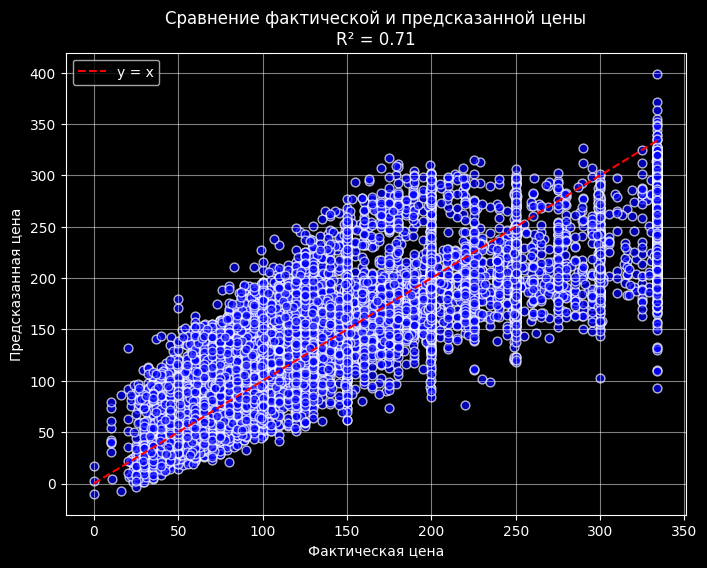

In [43]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolor='white', s=40)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlabel("Фактическая цена")
plt.ylabel("Предсказанная цена")
plt.title(f"Сравнение фактической и предсказанной цены\nR² = {r2:.2f}")

plt.legend()

##5.1 Стекинг

In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.9 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [ ]:
def objective_rf(trial):
    param_grid = {"n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])}

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_errors = np.empty(cv.get_n_splits())

    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]
        X_tr_processed = preprocessor.fit_transform(X_tr)
        X_val_processed = preprocessor.transform(X_val)

        model = RandomForestRegressor(**param_grid, random_state=42, n_jobs=-1)
        model.fit(X_tr_processed, y_tr)
        preds = model.predict(X_val_processed)
        cv_errors[idx] = mean_squared_error(y_val, preds)

    return np.mean(cv_errors)

In [ ]:
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=20)

In [ ]:
rf_params = study_rf.best_params
print(rf_params)

In [ ]:
def objective_knn(trial):
    param_grid = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 30),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"])
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_errors = np.empty(cv.get_n_splits())

    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_tr = X_train_fold.sample(frac=0.2, random_state=42)
        y_tr = y_train_fold.loc[X_tr.index]

        X_val = X_train.iloc[test_idx]
        y_val = y_train.iloc[test_idx]
        X_tr_processed = preprocessor.fit_transform(X_tr)
        X_val_processed = preprocessor.transform(X_val)


        model = Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("knn", KNeighborsRegressor(**param_grid))
        ])

        model.fit(X_tr_processed, y_tr)
        preds = model.predict(X_val_processed)
        cv_errors[idx] = mean_squared_error(y_val, preds)

    return np.mean(cv_errors)

In [ ]:
study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(objective_knn, n_trials=20)

In [ ]:
knn_params = study_knn.best_params
print(knn_params)

In [ ]:
!pip install optuna-integration[lightgbm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback

In [ ]:
X_train.columns = X_train.columns.str.replace(r"[^\w]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^\w]", "_", regex=True)


In [ ]:
from optuna.pruners import MedianPruner

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "verbosity": -1,
        "n_jobs": -1
    }

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        X_tr_processed = preprocessor.fit_transform(X_tr)
        X_val_processed = preprocessor.transform(X_val)
        model = lgb.LGBMRegressor(**params)
        model.fit(X_tr_processed, y_tr)
        preds = model.predict(X_val_processed)

        mse = mean_squared_error(y_val, preds)
        val_scores.append(mse)
        trial.report(mse, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()


    return np.mean(val_scores)

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=MedianPruner(
        n_startup_trials=3,
        n_warmup_steps=2,
        interval_steps=1
    )
)

study.optimize(objective, n_trials=20, timeout=3600)

In [ ]:
best_params = study.best_params
print(best_params)

In [ ]:
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

In [ ]:
from sklearn.ensemble import StackingRegressor

base_models = [
    ('ridge', Ridge(alpha=1, max_iter=1000, solver='auto', random_state=42)),
    ('rf', RandomForestRegressor(
        n_estimators=237,
        max_depth=27,
        min_samples_split=17,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )),
    ("lgb", lgb.LGBMRegressor(
    learning_rate=0.068,
    num_leaves=31,
    max_depth=5,
    min_data_in_leaf=20,
    feature_fraction=0.79,
    bagging_fraction=0.86,
    bagging_freq=5,
    lambda_l1=0.1,
    n_estimators=100,
    random_state=42,
    verbose=-1
    ))
]

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=KNeighborsRegressor(
        n_neighbors=9,
        weights='distance',
        metric='euclidean',
        n_jobs=-1
    ),
    cv=3,
    n_jobs=-1,
    passthrough=True
)

In [ ]:
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    verbose_feature_names_out=False
)

stacked_model.set_params(verbose=0)

StackingRegressor(cv=3,
                  estimators=[('ridge',
                               Ridge(alpha=1, max_iter=1000, random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=27,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=17,
                                                     n_estimators=237,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('lgb',
                               LGBMRegressor(bagging_fraction=0.86,
                                             bagging_freq=5,
                                             feature_fraction=0.79,
                                             lambda_l1=0.1, learning_rate=0.068,
                                             max_depth=5, min_data_in_leaf=20,
                                             random_state=42, verbose=-1))],
                  final_estimator=KNeighborsRegressor(metric='euclidean',
                                                      n_jobs=-1, n_neighbors=9,
                                                      weights='distance'),
                  n_jobs=-1, passthrough=True)

In [ ]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacked_model', stacked_model)
])

final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'price_per_night',
                                                   'center_distance', 'year',
                                                   'month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['neighbourhood_group',
                                                   'neighbourhood', 'room_type',
                                                   'd...
                                                                      n_estimators=237,
                                                                      n_jobs=-1,
                                                                      random_state=42)),
                                               ('lgb',
                                                LGBMRegressor(bagging_fraction=0.86,
                                                              bagging_freq=5,
                                                              feature_fraction=0.79,
                                                              lambda_l1=0.1,
                                                              learning_rate=0.068,
                                                              max_depth=5,
                                                              min_data_in_leaf=20,
                                                              random_state=42,
                                                              verbose=-1))],
                                   final_estimator=KNeighborsRegressor(metric='euclidean',
                                                                       n_jobs=-1,
                                                                       n_neighbors=9,
                                                                       weights='distance'),
                                   n_jobs=-1, passthrough=True))])

In [ ]:
y_fpred = final_pipeline.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
mean_squared_error(y_test, y_fpred)

344.6574016081828

In [ ]:
r2_score(y_test, y_fpred)

0.9502956257377082

##6. Кластеризация


In [44]:
from sklearn.cluster import KMeans
features = ['price', 'price_per_night', 'center_distance', 'minimum_nights', 'availability_365', 'reviews_per_month']
X_clust = df[features]

Выбираем те столбцы, которые будут использоваться для кластеризации. Это позволяет сфокусироваться на признаках, влияющих на распределение объектов (цена, цена за ночь, расстояние до центра, минимальное количество ночей, доступность за год и отзывы).

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)
eps_values = np.arange(0.05, 2.0, 0.15)
min_samples = 5

In [46]:
from sklearn.metrics import silhouette_score

Масштабирование признаков необходимо для метода К ближайших соседей.

In [50]:
wcss = []
silhouette_scores = []
K_range=range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

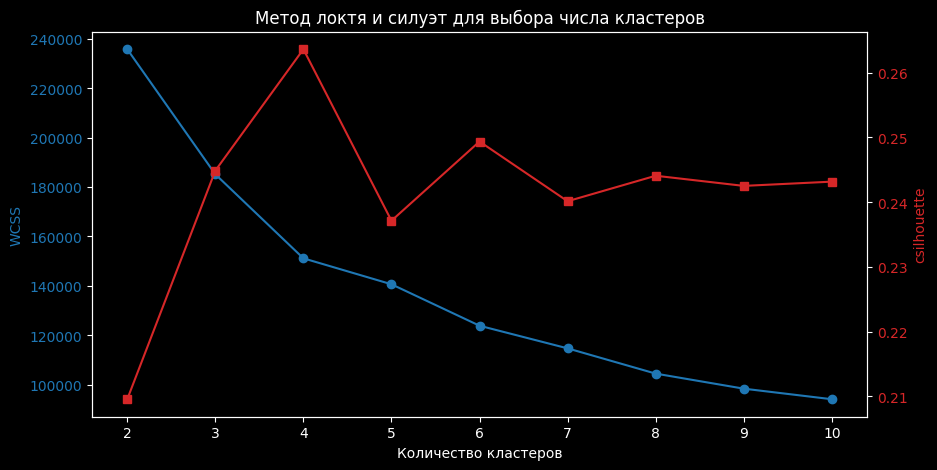

In [51]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(K_range, wcss, marker='o', color='tab:blue')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('WCSS', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Метод локтя и силуэт для выбора числа кластеров')

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_scores, marker='s', color='tab:red')
ax2.set_ylabel('сsilhouette', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

Как можно наблюдать из синего графика, оптимальным количеством кластеров является число 10, где wcss минимален. По видимому, график и далее будет показавыть нисходящее движение, но темп снижения замедляется, поскольку у него есть горизонтальная асимптота. Так что дальнейшие значения не сильно изменят ошибку.
Оптимальный силуэт достигается при 4 кластерах, поэтому столько и следует взять.

In [55]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [56]:
df['cluster_k'] = clusters


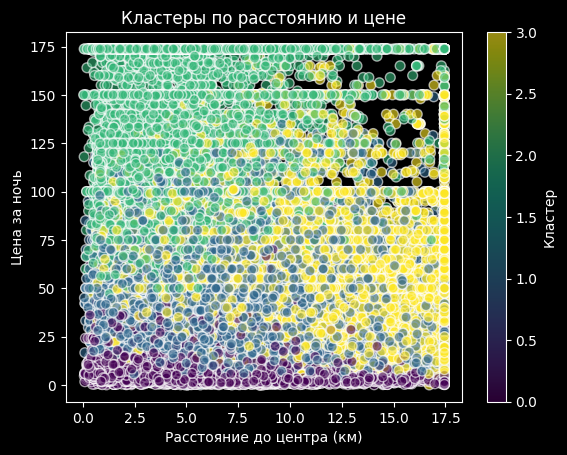

In [57]:
plt.scatter(df['center_distance'], df['price_per_night'],
            c=df['cluster_k'], cmap='viridis', alpha=0.6, edgecolors='w', s=50)
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Цена за ночь')
plt.title('Кластеры по расстоянию и цене')
plt.colorbar(label='Кластер')


На графике воспрнять 4 кластера довольно тяжело, хотя видны некоторые границы разделения.

In [58]:
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=features)
centers_df

,price,price_per_night,center_distance,minimum_nights,availability_365,reviews_per_month
0,136.084523,8.007462,6.524057,10.361142,188.524332,0.571571
1,100.745617,44.199047,7.033702,2.969540,23.806278,0.544320
2,253.024092,135.191585,5.196557,2.130913,126.027503,1.135420
3,92.768848,54.666633,9.884686,2.061782,192.582933,2.331864


Первый кластер характеризуется относительно низкой ценой
 около 136 долларов, но при этом цена за ночь всего 8, что говорит о долгосрочной аренде и значительных скидках. Минимальное количество ночей выше среднего, удаленность примерно 6,5 км от центра. Доступность высокая, почти весь год, а количество отзывов в месяц низкое.

Второй кластер отличается умеренной стоимостью около 100 долларов, с ценой за ночь 44. Это больше похоже на краткосрочную аренду. Минимальное количество ночей небольшое, около 3, доступность низкая. Объекты находятся дальше — более 7 км от центра.

Третий кластер это дорогие варианты с ценой около 253 долларов и ценой за ночь более 135. Эти предложения ближе к центру , минимальное количество ночей примерно 2, доступность умеренная, а отзывов больше, чем в других кластерах.

Четвёртый кластер снова относится к более доступному сегменту цена около 92 долларов, цена за ночь 54. Удаленность максимальная почти 10 км, минимальные ночи около 2, доступность высокая, а количество отзывов в месяц самое большое, что указывает на популярность среди гостей.

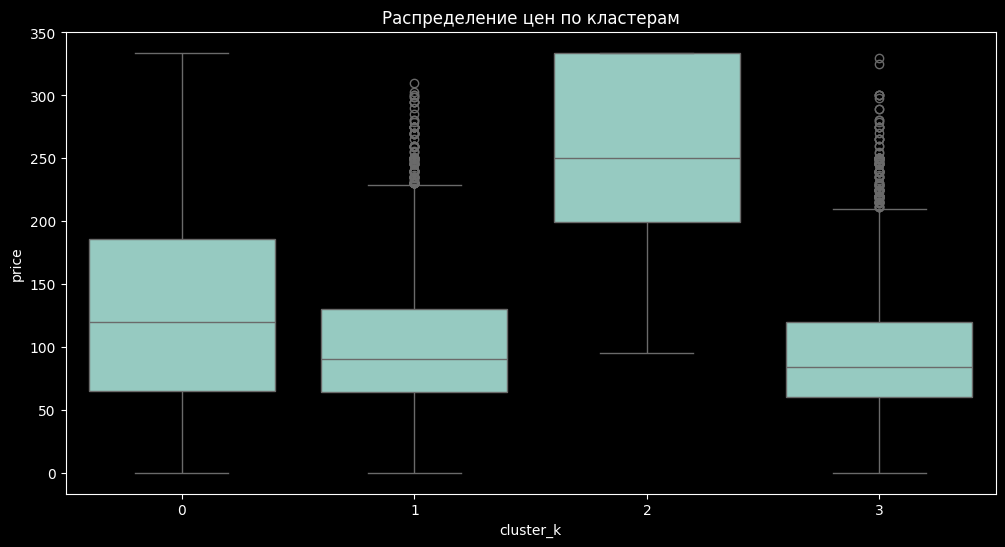

In [59]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df["cluster_k"], y=df["price"])
plt.title("Распределение цен по кластерам")
plt.show()


Здесь как раз можно видеть что средняя цена во 2 кластре значительно выделяется.

/tmp/ipython-input-2619673378.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster_k", y="reviews_per_month", palette="coolwarm")


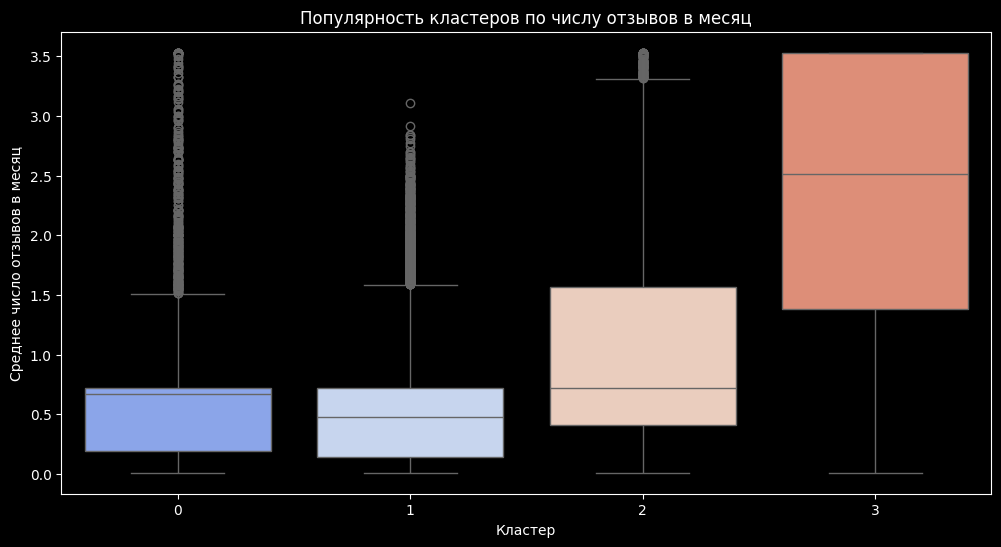

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="cluster_k", y="reviews_per_month", palette="coolwarm")
plt.title("Популярность кластеров по числу отзывов в месяц")
plt.xlabel("Кластер")
plt.ylabel("Среднее число отзывов в месяц")
plt.show()



3 и 4 кластеры самые популярные.

/tmp/ipython-input-4030234186.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster_k", y="availability_365", palette="magma")


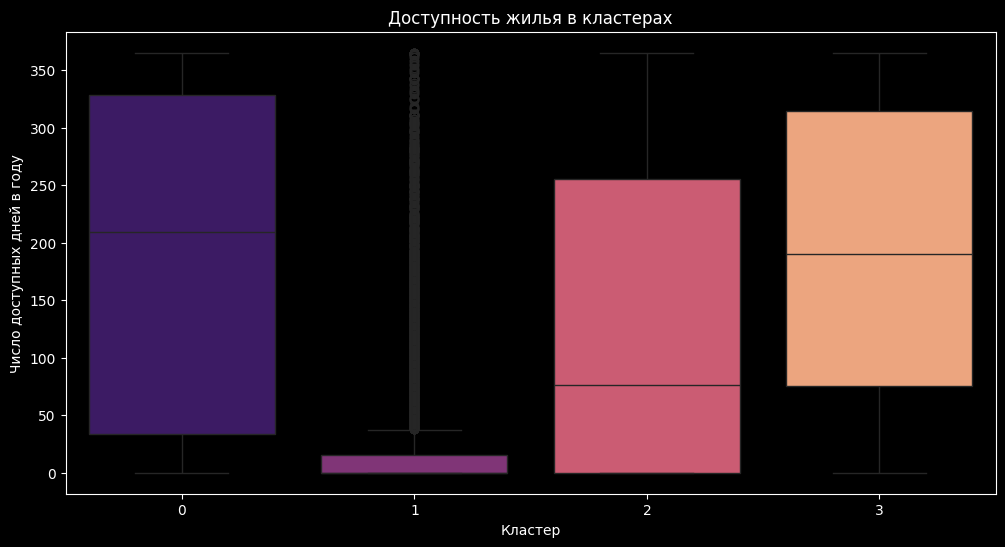

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="cluster_k", y="availability_365", palette="magma")
plt.title("Доступность жилья в кластерах")
plt.xlabel("Кластер")
plt.ylabel("Число доступных дней в году")
plt.show()



0 и 3 кластеры характеризуются высокой доступностью жилья.